In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [56]:
import pickle
with open('raw_data_20181008.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)
    
copy_keys = list(raw_data.keys())
for stock in copy_keys:
    if len(raw_data[stock].loc[:'2013-01-01']) < 1:
        del raw_data[stock]
del copy_keys

# stock에서 Volume==0인 index, stock에서 제외
for key, df in raw_data.items():
    raw_data[key] = df.drop(df.index[np.where(df.Volume==0)[0]], axis=0)
    del df['Adj Close']
    df.Volume = df.Volume / 1e7

In [58]:
for key, df in raw_data.items():
    if key != '삼성전자':
        continue
    print(key)
    for i in range(1, 31, 2):
        df['returnsCloseNext{}'.format(i)] = np.log(df['Close'].shift(-1*i) / df['Open'])

    # Moving Average
    df['close_ma_50'] = df.Close.rolling(50).mean()

    # Return of Change
    df['roc_1'] = df.Close.pct_change(periods=1)
    df['roc_2'] = df.Close.pct_change(periods=2)

    # RSI
    U = np.where(df.Close.diff(1) > 0, df.Close.diff(1), 0)
    D = np.where(df.Close.diff(1) < 0, df.Close.diff(1)*(-1), 0)
    m_N = 10
    AU = pd.DataFrame(U).rolling(window=m_N, min_periods=m_N).mean()
    AD = pd.DataFrame(D).rolling(window=m_N, min_periods=m_N).mean()
    RSI = AU.div(AD+AU)*100
    df['rsi_10'] = RSI.values

    # CV
    df['his_vol_10'] = df.Close.rolling(10).std() / df.Close.rolling(10).mean()

    # William%R
    n = 14
    W_R = -100 * ((df.High.rolling(n).max() - df.Close) / 
       (df.High.rolling(n).max() - df.Low.rolling(n).min()))
    df['w_r'] = W_R

    # Stochastic Oscillator
    percent_K = 100 * ((df.Close - df.Low.rolling(n).min()) / 
       (df.High.rolling(n).max() - df.Low.rolling(n).min()))
    sto_slowD = percent_K.rolling(3).mean().rolling(3).mean()
    df['sto_slowD'] = sto_slowD

    # Commodity Channel Index
    TP = (df.Close + df.Low + df.High) / 3
    window = 20
    dataX = []
    for i in range(len(TP) - window+1):
        a = TP.values[i:(i+window)]
        dataX.append(a)
    dataMean = [i.mean() for i in dataX]
    AVEDEV = [abs(x - mean).mean() for x, mean 
              in zip(dataX, dataMean)]
    for i in range(window-1):
        AVEDEV.insert(0,np.nan)
    AVEDEV = pd.Series(AVEDEV, index = TP.index)
    CCI = (TP - TP.rolling(20).mean()) / (0.015 * AVEDEV)
    df['cci'] = CCI

    # Disparity Index
    DI5 = 100 * ((df.Close - df.Close.rolling(5).mean()) / 
                df.Close.rolling(5).mean())
    DI10 = 100 * ((df.Close - df.Close.rolling(10).mean()) / 
                df.Close.rolling(10).mean())
    df['di5'] = DI5
    df['di10'] = DI10

    # Volume Prce Trend
    VPT = pd.Series(index=df.index)
    VPT.iloc[0] = 0
    for n in range(1, len(VPT)):
        VPT.iloc[n] = VPT.iloc[n-1] + ((df.Close.diff(1) / df.Close) * df.Volume).iloc[n]
    df['vpt'] = VPT

삼성전자


In [59]:
for key, df in raw_data.items():
    raw_data[key] = df.dropna()

In [60]:
y_li = [col for col in raw_data['삼성전자'].columns if col.find('Next') != -1]
X_li = [col for col in raw_data['삼성전자'].columns if col.find('Next') == -1]

In [61]:
y_li

['returnsCloseNext1',
 'returnsCloseNext3',
 'returnsCloseNext5',
 'returnsCloseNext7',
 'returnsCloseNext9',
 'returnsCloseNext11',
 'returnsCloseNext13',
 'returnsCloseNext15',
 'returnsCloseNext17',
 'returnsCloseNext19',
 'returnsCloseNext21',
 'returnsCloseNext23',
 'returnsCloseNext25',
 'returnsCloseNext27',
 'returnsCloseNext29']

In [62]:
X_li

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'close_ma_50',
 'roc_1',
 'roc_2',
 'rsi_10',
 'his_vol_10',
 'w_r',
 'sto_slowD',
 'cci',
 'di5',
 'di10',
 'vpt']

In [63]:
from xgboost import XGBRegressor

In [64]:
raw_data['삼성전자'].head()

,Open,High,Low,Close,Adj Close,Volume,returnsCloseNext1,returnsCloseNext3,returnsCloseNext5,returnsCloseNext7,...,roc_1,roc_2,rsi_10,his_vol_10,w_r,sto_slowD,cci,di5,di10,vpt
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-16,15360.0,15400.0,15160.0,15300.0,5.629467,16548150,0.038319,0.045810,0.052009,0.064294,...,-0.003906,-0.016710,45.614035,0.011390,-47.540984,69.167361,-27.848821,-1.239349,-1.315789,-1.142002e+06
2010-03-17,15440.0,15960.0,15420.0,15960.0,5.872307,21840650,0.031870,0.036876,0.059100,0.060320,...,0.043137,0.039062,65.168539,0.014410,-0.000000,66.484517,127.343354,2.649859,2.583880,-2.388175e+05
2010-03-18,15900.0,16140.0,15900.0,15940.0,5.864948,15393500,0.011257,0.017457,0.029742,0.028520,...,-0.001253,0.041830,72.500000,0.014020,-13.513514,70.265347,170.080321,2.022529,1.983365,-2.581318e+05
2010-03-19,16020.0,16140.0,15960.0,16080.0,5.916459,10711200,0.000000,0.022223,0.023443,0.016099,...,0.008783,0.007519,69.863014,0.016240,-5.882353,81.042856,160.791096,2.238047,2.498725,-1.648750e+05
2010-03-22,16060.0,16080.0,15840.0,16020.0,5.894383,9191800,0.007444,0.019729,0.018508,0.018508,...,-0.003731,0.005019,61.538462,0.017544,-11.764706,87.598785,120.734908,1.008827,1.921364,-1.993013e+05


In [65]:
from sklearn import metrics

In [66]:
import time

In [67]:
for key, df in raw_data.items():
    raw_data[key] = df.loc['2013-01-01':]

In [78]:
result = {}
start = time.time()
y = 'returnsCloseNext29'
for key, df in raw_data.items():
    if key != '삼성전자':
        continue
    semi_start = time.time()
    
    train_data = df.iloc[:int(0.8*len(df))][X_li].values
    train_label = df.iloc[:int(0.8*len(df))][y].values
    test_data = df.iloc[int(0.8*len(df)):][X_li].values
    test_label = df.iloc[int(0.8*len(df)):][y]
    xgb_reg = XGBRegressor()
    xgb_reg.fit(train_data, train_label)
    pred = pd.Series(xgb_reg.predict(test_data), index=test_label.index)
    rmse = metrics.mean_squared_error(test_label.values, pred.values) ** .5
    accuracy = metrics.accuracy_score(np.where(test_label.values>0, 1, 0), 
                       np.where(pred.values>0, 1, 0))
    result[key] = [rmse, accuracy, pred]
    
    semi_elapse = time.time() - semi_start
    print('Done :', key, '\n\t{:.4f} sec'.format(semi_elapse))

Done : 삼성전자 
	0.1745 sec


In [79]:
for key, data in result.items():
    if key != '삼성전자':
        continue
    print(key, '\n\t RMSE:{:.3f}\tAccuracy:{:.4f}'.format(data[0], data[1]))

삼성전자 
	 RMSE:0.110	Accuracy:0.4239


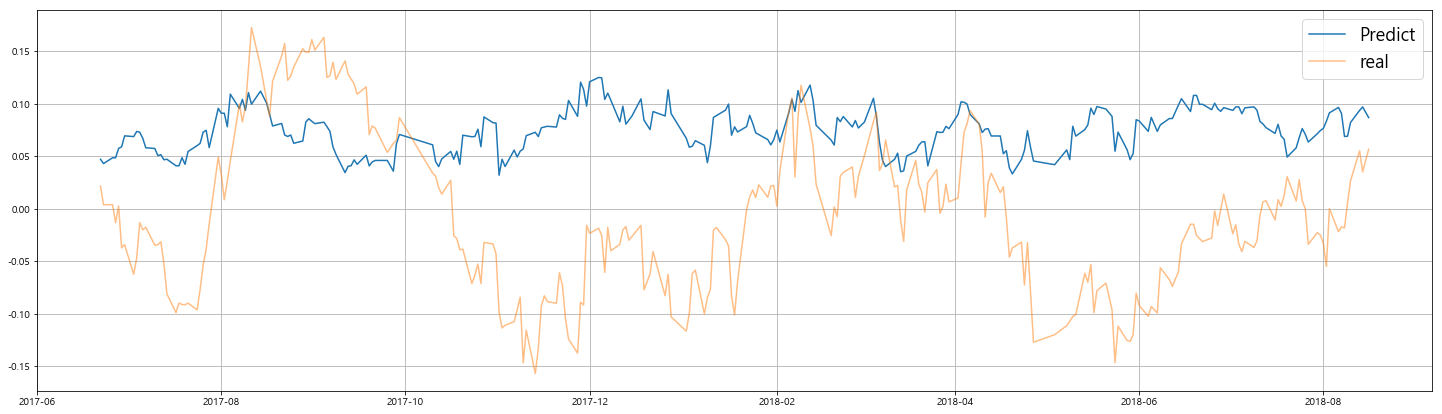

In [80]:
plt.figure(figsize=(25,7))
plt.plot(result['삼성전자'][2], label='Predict', alpha=1)
plt.plot(raw_data['삼성전자'].iloc[int(0.8*len(raw_data['삼성전자'])):][y], label='real', alpha=.5)
plt.grid(True)
plt.legend(fontsize=18)

Text(0.5,1,'1일 후 예측')

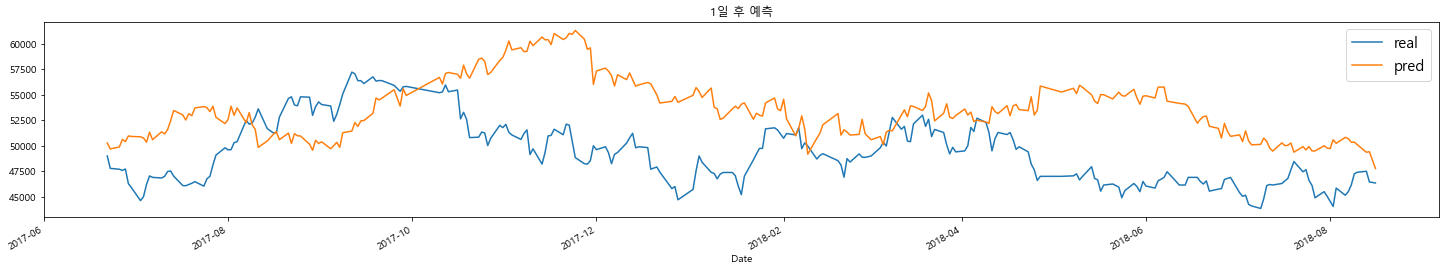

In [81]:
real = raw_data['삼성전자'].iloc[int(0.8*len(raw_data['삼성전자'])):]
t = pd.concat((np.exp(real[y] + np.log(real['Open'])), 
               np.exp(result['삼성전자'][2] + np.log(real['Open']))), 
              axis=1)
t.columns = ['real', 'pred']
t.plot(figsize=(25,4))
plt.legend(fontsize=15)
plt.title('1일 후 예측')